In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import bz2
from tqdm import tqdm
import os

In [2]:
events = []
total_size = 0
for file_name in tqdm(os.listdir('../Data/')):
    if 'txt.bz2' in file_name:
        with bz2.open('../Data/{}'.format(file_name), 'r') as f:
            file = f.readlines()
            print('total shape of {} is ({}, {})'.format(file_name, len(file), len(file[0].split())))
            event_matrix = np.zeros((len(file), len(file[0].split())), dtype=np.int16)
            for ind, event in enumerate(file):
                event_matrix[ind, :] = [int(i) for i in event.split()]
            local_size = event_matrix.size * event_matrix.itemsize / 1024 / 1024 / 1024 # ~250 MB
            total_size += local_size
            print('Total size {}\t Local size {}'.format(total_size, local_size))
            events.append(event_matrix)

  0%|          | 0/14 [00:00<?, ?it/s]

total shape of event2.txt.bz2 is (30720, 4495)


  7%|▋         | 1/14 [02:15<29:23, 135.62s/it]

Total size 0.2572059631347656	 Local size 0.2572059631347656
total shape of event3.txt.bz2 is (30720, 4495)


 14%|█▍        | 2/14 [04:15<26:10, 130.90s/it]

Total size 0.5144119262695312	 Local size 0.2572059631347656
total shape of event1.txt.bz2 is (30720, 4495)


KeyboardInterrupt: 

In [39]:
events = np.row_stack(events)

In [41]:
with open('../Data/full_events.npy', 'wb') as f:
    np.save(f, events, allow_pickle=False)

### Start here

In [3]:
with open('../Data/full_events.npy', 'rb') as f:
    events = np.load(f, allow_pickle=False)

In [4]:
events

array([[    8,     0,     0, ...,  1801,  1805,  1803],
       [    8,     1,     0, ...,  1802,  1802,  1800],
       [    8,     2,     0, ...,  1804,  1803,  1793],
       ...,
       [    8, 30717,     1, ...,   499,   496,   496],
       [    8, 30718,     1, ...,   500,   502,   501],
       [    8, 30719,     1, ...,   502,   499,   496]], dtype=int16)

In [5]:
events.shape

(30720, 4495)

In [6]:
collection_channels = events[events[:, 2] == 1][:, 3:]
readout_channels = events[events[:, 2] == 0][:, 3:]

In [7]:
readout_channels

array([[1805, 1800, 1802, ..., 1801, 1805, 1803],
       [1803, 1801, 1803, ..., 1802, 1802, 1800],
       [1803, 1802, 1796, ..., 1804, 1803, 1793],
       ...,
       [1800, 1801, 1800, ..., 1805, 1797, 1795],
       [1797, 1794, 1797, ..., 1795, 1796, 1804],
       [1795, 1795, 1798, ..., 1799, 1803, 1799]], dtype=int16)

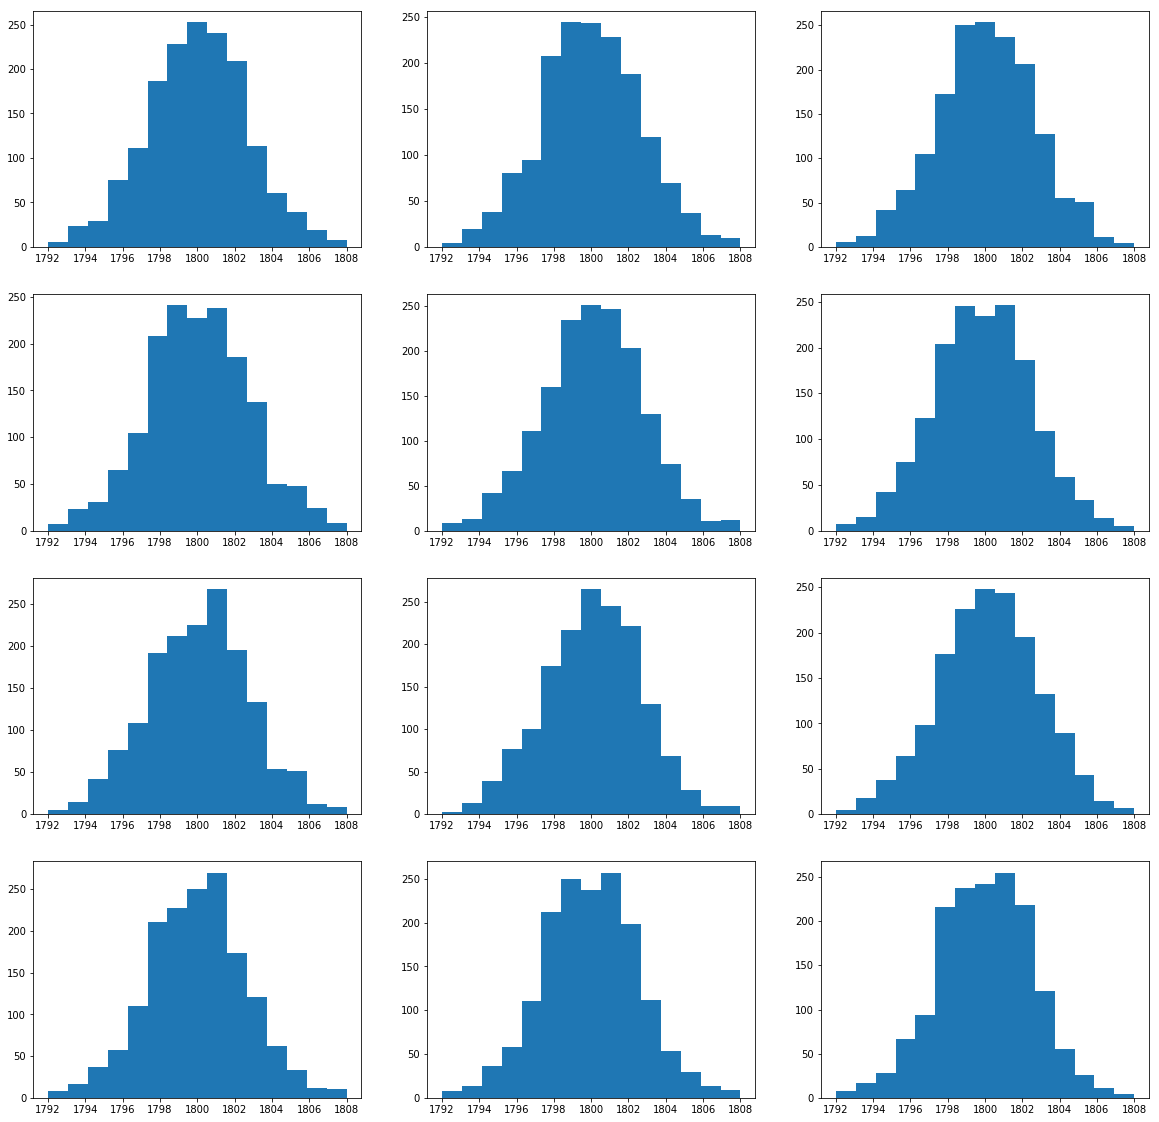

In [8]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
bbins = 15

for i in range(12):
    _, bbins, _ = axes[i%4][i//4].hist(readout_channels[i*1600:(i+1)*1600, 10], bins=bbins)
    
plt.show()

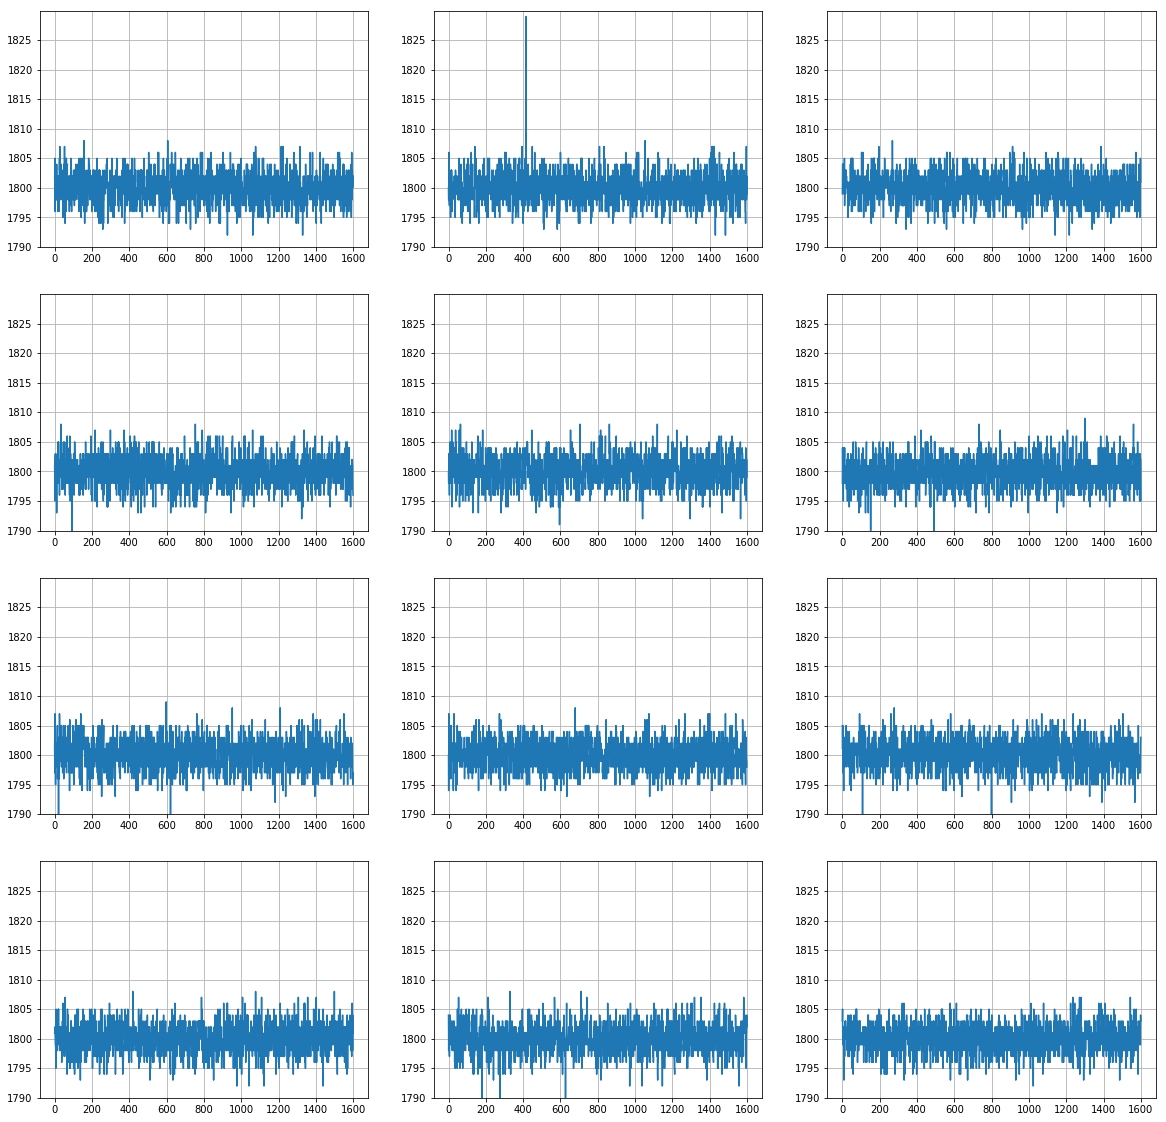

In [9]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

for i in range(12):
    axes[i%4][i//4].plot(readout_channels[i*1600:(i+1)*1600, 10])
    axes[i%4][i//4].set_yticks(np.arange(1790, 1830, 5))
    axes[i%4][i//4].set_ylim((1790, 1830))
    axes[i%4][i//4].grid()
    
plt.show()

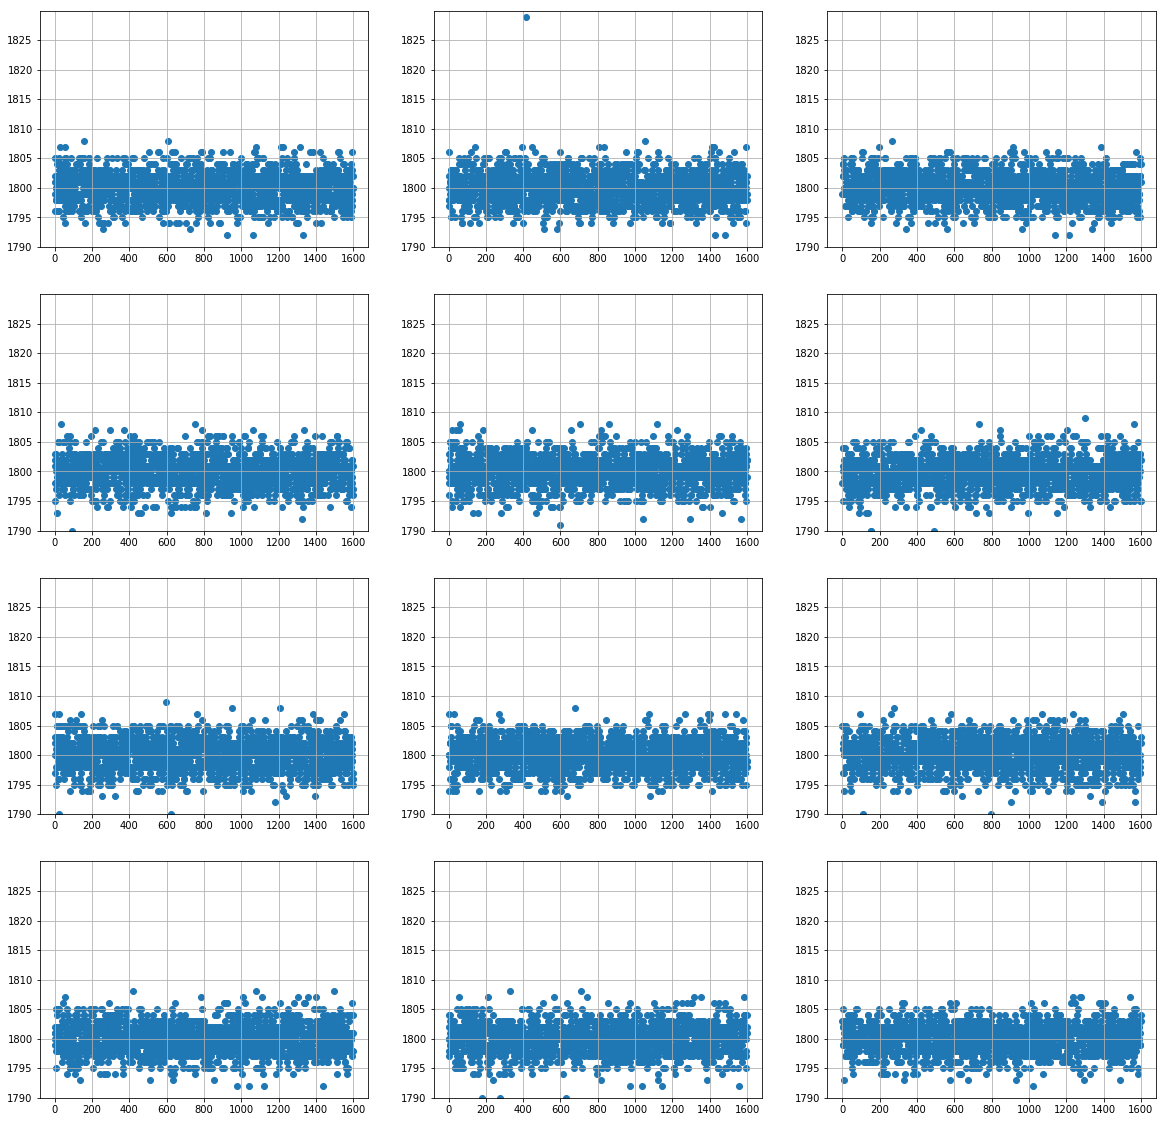

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

for i in range(12):
    axes[i%4][i//4].scatter(range(1600), readout_channels[i*1600:(i+1)*1600, 10])
    axes[i%4][i//4].set_yticks(np.arange(1790, 1830, 5))
    axes[i%4][i//4].set_ylim((1790, 1830))
    axes[i%4][i//4].grid()
    
plt.show()

In [21]:
readout_channels = readout_channels - 1800

100%|██████████| 600/600 [00:22<00:00, 25.51it/s]


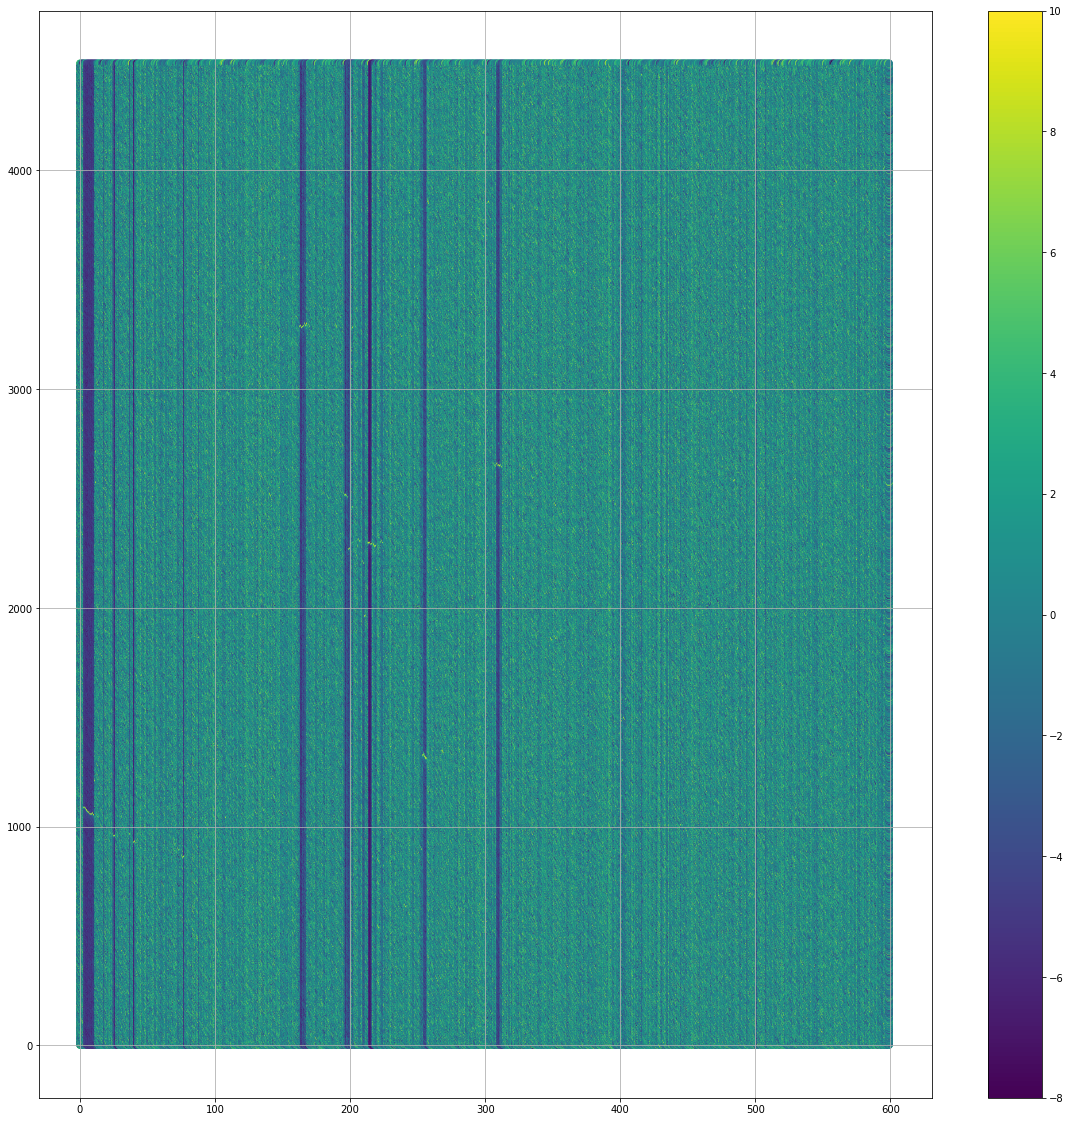

In [25]:
plt.figure(figsize=(20, 20))


for channel in tqdm(range(600)):
    plt.scatter([channel]*readout_channels.shape[1], range(readout_channels.shape[1]), c=readout_channels[channel, :])


plt.colorbar()
plt.grid()
plt.show()

In [41]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

def plot_plane(adcs, figsize=None):
    if not figsize:
        figsize = (20, 20)
    plt.figure(figsize=(20, 20))
    y, x = np.mgrid[slice(0, adcs.shape[1], 1),
                    slice(0, adcs.shape[0], 1)]
    z = adcs.T
    levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())
    cmap = plt.get_cmap('PiYG')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    plt.pcolormesh(x, y, z, cmap=cmap, norm=norm)
    plt.colorbar()
    plt.title('pcolormesh with levels')
    fig.tight_layout()
    plt.show()


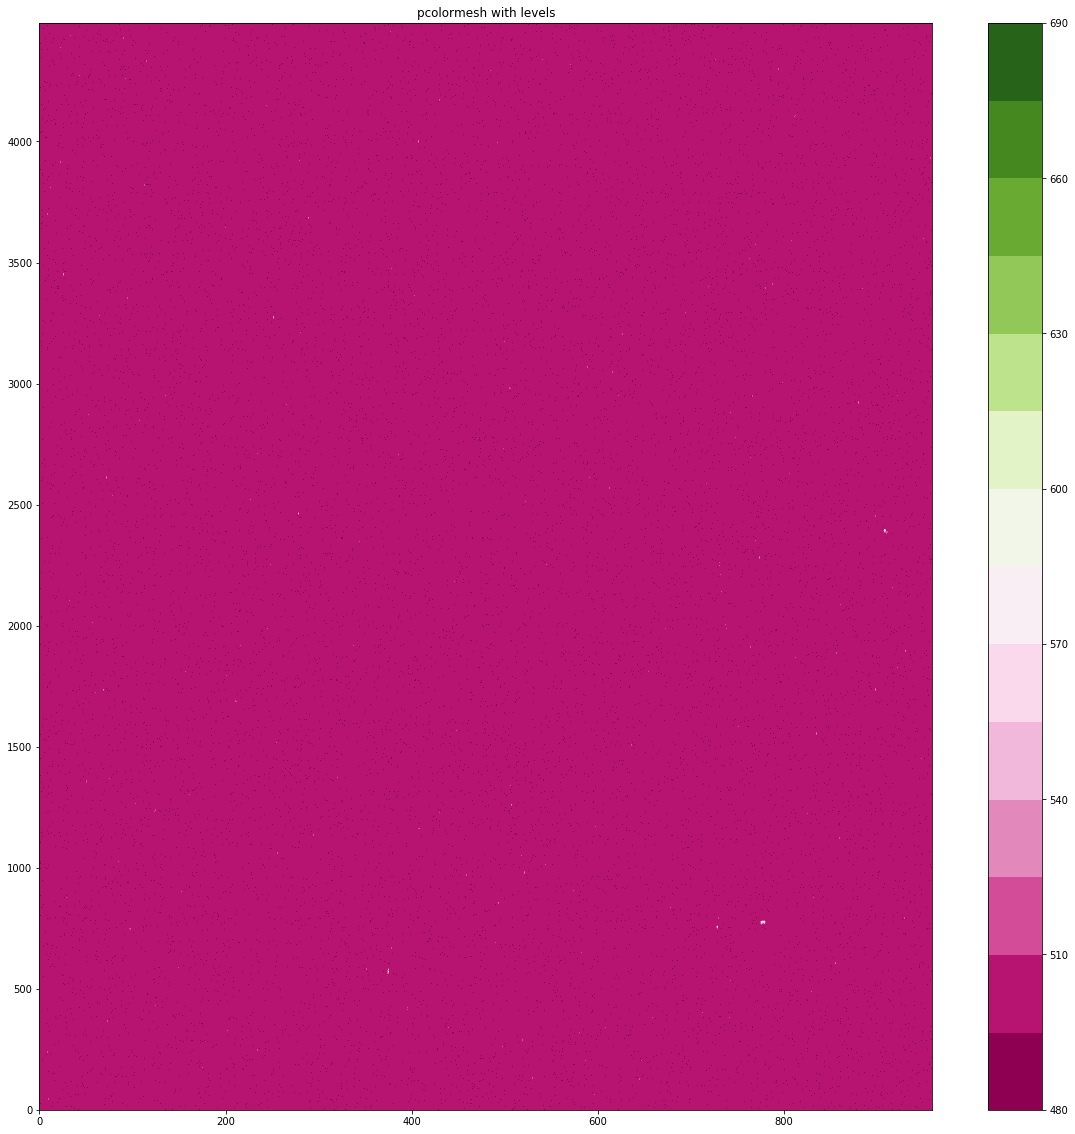

In [43]:
plot_plane(collection_channels[-960*5:-960*4])

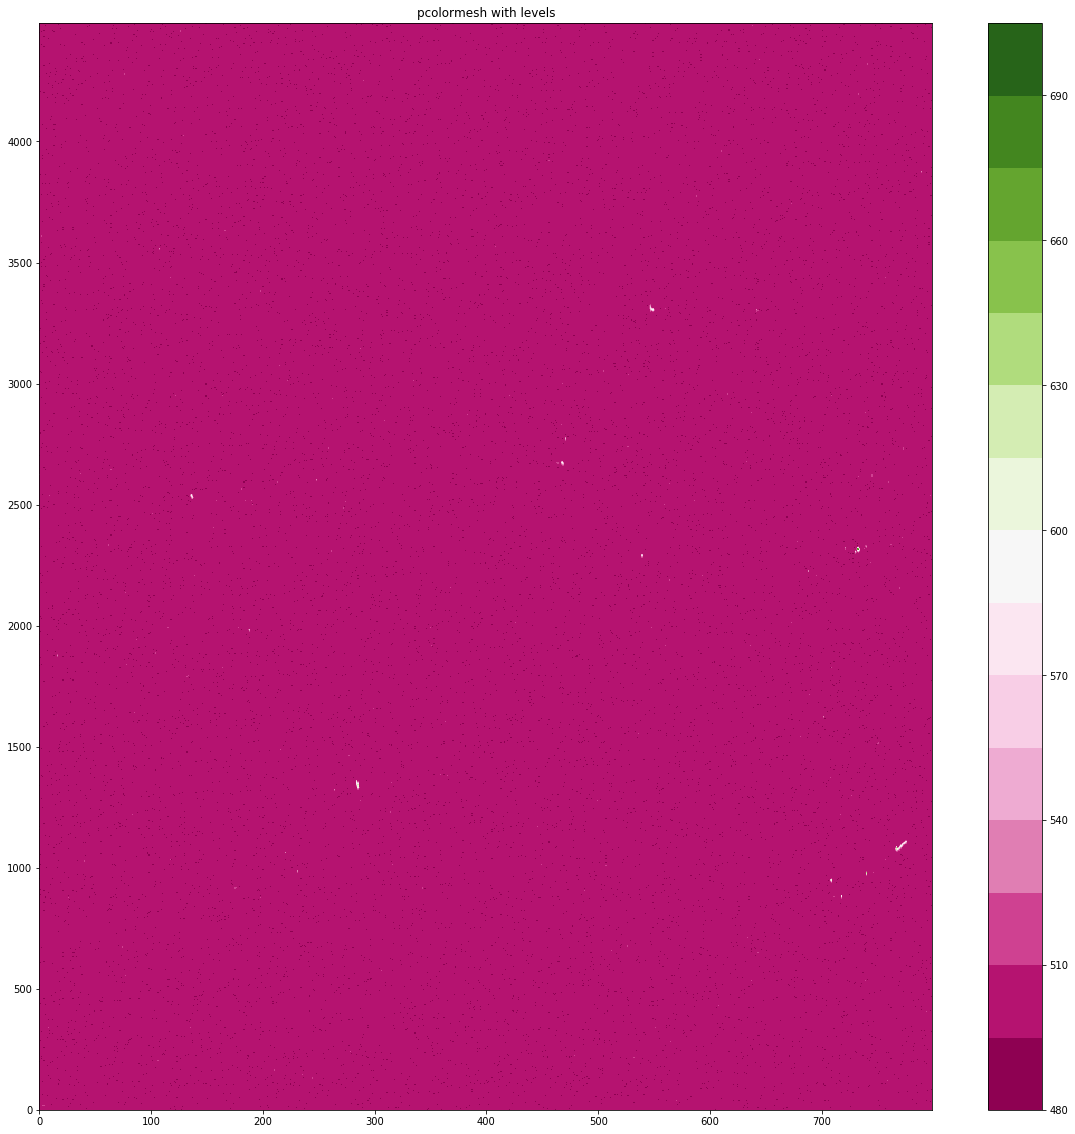

In [36]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(20, 20))

# make these smaller to increase the resolution

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, collection_channels.shape[1], 1),
                slice(0, 800, 1)]

z = collection_channels[:800].T

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.

levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)


plt.pcolormesh(x, y, z, cmap=cmap, norm=norm)
plt.colorbar()
plt.title('pcolormesh with levels')

fig.tight_layout()

plt.show()

In [32]:
z.min()

-12

In [26]:
dx, dy = 0.05, 0.05

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(1, 5 + dy, dy),
                slice(1, 5 + dx, dx)]


In [27]:
x

array([[1.  , 1.05, 1.1 , ..., 4.9 , 4.95, 5.  ],
       [1.  , 1.05, 1.1 , ..., 4.9 , 4.95, 5.  ],
       [1.  , 1.05, 1.1 , ..., 4.9 , 4.95, 5.  ],
       ...,
       [1.  , 1.05, 1.1 , ..., 4.9 , 4.95, 5.  ],
       [1.  , 1.05, 1.1 , ..., 4.9 , 4.95, 5.  ],
       [1.  , 1.05, 1.1 , ..., 4.9 , 4.95, 5.  ]])